Found 788 images belonging to 7 classes.
Found 193 images belonging to 7 classes.
Epoch 1/50


C:\Users\HP\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


13/13 ━━━━━━━━━━━━━━━━━━━━ 9s 246ms/step - accuracy: 0.1863 - loss: 1.8948 - val_accuracy: 0.2539 - val_loss: 1.8521
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 174ms/step - accuracy: 0.2663 - loss: 1.8128 - val_accuracy: 0.2539 - val_loss: 1.9518
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 156ms/step - accuracy: 0.2300 - loss: 1.8367 - val_accuracy: 0.2539 - val_loss: 1.7793
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 167ms/step - accuracy: 0.2215 - loss: 1.8252 - val_accuracy: 0.2539 - val_loss: 1.9326
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 174ms/step - accuracy: 0.2346 - loss: 1.8352 - val_accuracy: 0.2539 - val_loss: 1.7797
Epoch 6/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 189ms/step - accuracy: 0.2577 - loss: 1.7762 - val_accuracy: 0.2539 - val_loss: 1.7634
Epoch 7/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 169ms/step - accuracy: 0.2467 - loss: 1.7662 - val_accuracy: 0.2539 - val_loss: 1.7064
Epoch 8/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 174ms/step - accuracy: 0.2669 - loss: 1.7504 - val_accuracy: 0.3161 - val_

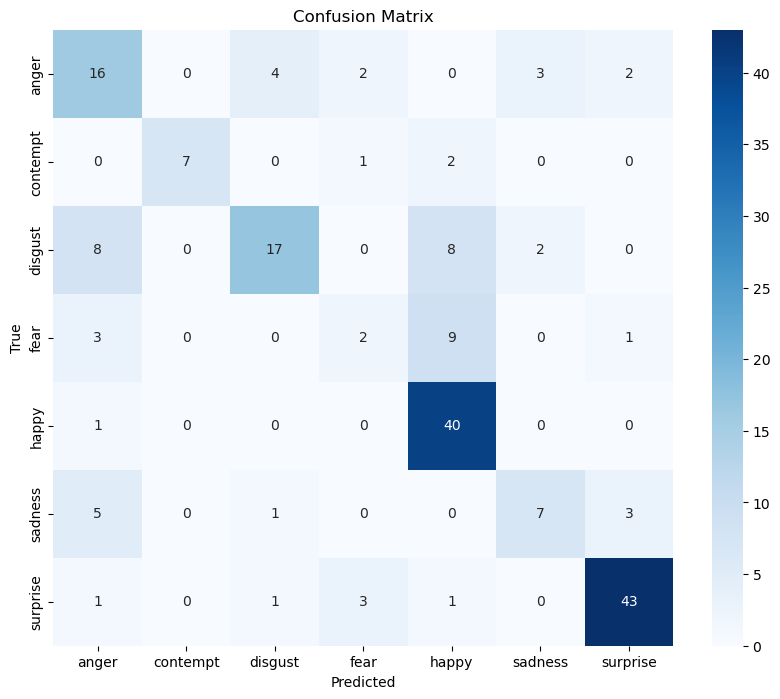

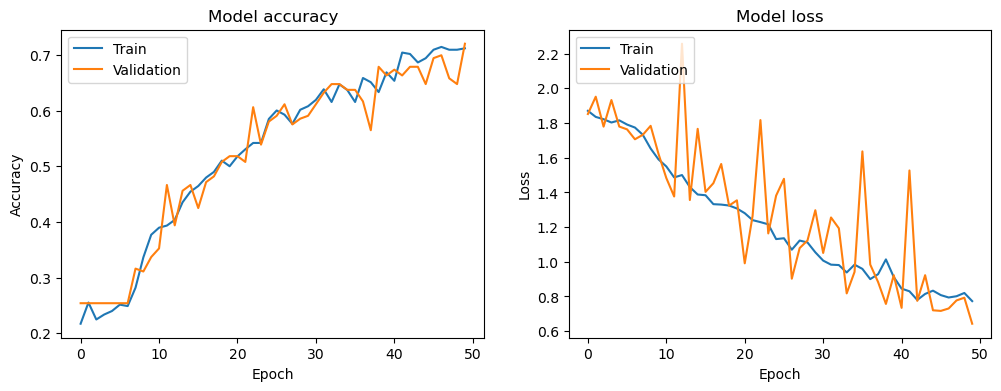

In [7]:
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Define the path to the dataset
data_dir = r"C:\Users\HP\Downloads\archive (8)\ck\CK+48"

# Check if the directory exists
if not os.path.exists(data_dir):
    raise FileNotFoundError(f"Dataset directory '{data_dir}' not found.")

# Load and preprocess the dataset
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(48, 48),
    batch_size=64,
    color_mode='grayscale',
    class_mode='categorical',
    subset='training'
)

validation_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(48, 48),
    batch_size=64,
    color_mode='grayscale',
    class_mode='categorical',
    subset='validation'
)

# Build the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 1)),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(7, activation='softmax')  # Assuming 7 classes of facial expressions
])

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss')

# Train the model
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=validation_generator,
    callbacks=[early_stopping, model_checkpoint]
)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(validation_generator)
print(f'Test accuracy: {test_accuracy * 100:.2f}%')

# Load the best model
model.load_weights('best_model.keras')

# Predict on the validation set
val_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(48, 48),
    batch_size=64,
    color_mode='grayscale',
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

Y_pred = model.predict(val_generator)
y_pred = np.argmax(Y_pred, axis=1)
y_true = val_generator.classes

# Print classification report
print(classification_report(y_true, y_pred, target_names=val_generator.class_indices.keys()))

# Plot confusion matrix
conf_mat = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=val_generator.class_indices.keys(), yticklabels=val_generator.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()
